# Import

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import zipfile
import json
import os
import shutil
import scipy.io
from collections import Counter
import pandas as pd
import matplotlib.pyplot as plt
import random
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import itertools
import sklearn
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import cv2
from collections import Counter
from tensorflow.keras import mixed_precision
import json
import pickle

In [ ]:
from tensorflow import keras
import tensorflow as tf
from tensorflow.compat.v1 import ConfigProto, InteractiveSession
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, CSVLogger

In [ ]:
mixed_precision.set_global_policy('mixed_float16')

# เตรียม Dataset

In [ ]:
zip_path = "/content/drive/MyDrive/Datasets/stanford_car_dataset_by_classes.zip"
extract_path = "/content/Dataset"

# สร้างโฟลเดอร์ถ้ายังไม่มี
os.makedirs(extract_path, exist_ok=True)

# แตกไฟล์
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

In [ ]:
DATASET_DIR = "/content/Dataset"

TRAIN_DIR = os.path.join(DATASET_DIR, "car_data", "car_data", "train")
TEST_DIR = os.path.join(DATASET_DIR, "car_data", "car_data", "test")

📊 ตัวอย่างจำนวนภาพใน train:
                                        Class  Train Images
140                       GMC Savana Van 2012            68
131                   Chrysler 300 SRT-8 2010            49
173  Mercedes-Benz 300-Class Convertible 1993            48
135              Mitsubishi Lancer Sedan 2012            48
82                Chevrolet Corvette ZR1 2012            47
78                         Jaguar XK XKR 2012            47
69                     Dodge Durango SUV 2007            46
92                  Suzuki Kizashi Sedan 2012            46
80                         Ford GT Coupe 2006            46
100                Eagle Talon Hatchback 1998            46


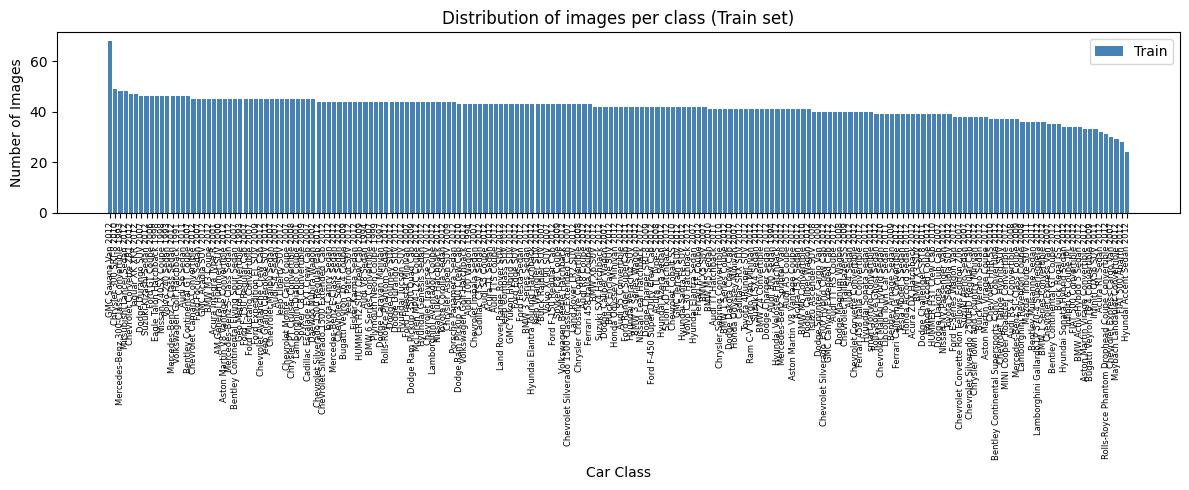


รวมทั้งหมด:
Train: 8144 รูป
รวมทั้งหมด 196 คลาส


In [ ]:
# นับจำนวนภาพในแต่ละโฟลเดอร์
train_counts = Counter()
for cls in os.listdir(TRAIN_DIR):
    cls_path = os.path.join(TRAIN_DIR, cls)
    if os.path.isdir(cls_path):
        n_images = len([f for f in os.listdir(cls_path) if f.lower().endswith(('.jpg', '.png', '.jpeg'))])
        train_counts[cls] = n_images

# สร้าง DataFrame
train_df = pd.DataFrame(train_counts.items(), columns=["Class", "Train Images"])
train_df = train_df.sort_values("Train Images", ascending=False)

# แสดงตัวอย่าง
print("📊 ตัวอย่างจำนวนภาพใน train:")
print(train_df.head(10))

# พล็อตกราฟ
plt.figure(figsize=(12, 5))
plt.bar(train_df["Class"], train_df["Train Images"], color="steelblue", label="Train")
plt.title("Distribution of images per class (Train set)")
plt.xlabel("Car Class")
plt.ylabel("Number of Images")
plt.xticks(rotation=90, fontsize=6)
plt.legend()
plt.tight_layout()
plt.show()

print("\nรวมทั้งหมด:")
print(f"Train: {train_df['Train Images'].sum()} รูป")
print(f"รวมทั้งหมด {len(train_df)} คลาส")

In [ ]:
ROOT_DIR = "/content/Dataset/car_data/car_data/train"
OUTPUT_DIR = "/content/FinalDataset"
TRAIN_OUT = os.path.join(OUTPUT_DIR, "train")
VAL_OUT = os.path.join(OUTPUT_DIR, "val")

TRAIN_RATIO = 0.75
VAL_RATIO = 0.25

random.seed(42)  # reproducible

# สร้างโฟลเดอร์ปลายทาง
os.makedirs(TRAIN_OUT, exist_ok=True)
os.makedirs(VAL_OUT, exist_ok=True)

# วนทุก class
for class_name in tqdm(os.listdir(ROOT_DIR), desc="Splitting"):
    class_path = os.path.join(ROOT_DIR, class_name)
    if not os.path.isdir(class_path):
        continue

    images = [f for f in os.listdir(class_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    if len(images) == 0:
        continue

    random.shuffle(images)

    # คำนวณจำนวนภาพแต่ละชุด
    n_total = len(images)
    n_train = int(round(n_total * TRAIN_RATIO))
    n_val = n_total - n_train  # เพื่อให้รวมกันครบพอดี

    train_imgs = images[:n_train]
    val_imgs   = images[n_train:]

    # สร้างโฟลเดอร์ class สำหรับแต่ละชุด
    os.makedirs(os.path.join(TRAIN_OUT, class_name), exist_ok=True)
    os.makedirs(os.path.join(VAL_OUT, class_name), exist_ok=True)

    # copy ไปแต่ละชุด
    for img in train_imgs:
        shutil.copy2(os.path.join(class_path, img),
                     os.path.join(TRAIN_OUT, class_name, img))

    for img in val_imgs:
        shutil.copy2(os.path.join(class_path, img),
                     os.path.join(VAL_OUT, class_name, img))

Splitting: 100%|██████████| 196/196 [00:05<00:00, 37.75it/s]


In [ ]:
def count_imgs(path):
    total = 0
    for cls in os.listdir(path):
        cls_dir = os.path.join(path, cls)
        if os.path.isdir(cls_dir):
            total += len(os.listdir(cls_dir))
    return total

print("Train images:", count_imgs(TRAIN_OUT))
print("Val images:  ", count_imgs(VAL_OUT))
print("Test images:  ", count_imgs(TEST_DIR))

Train images: 6114
Val images:   2030
Test images:   8041


# Train

In [ ]:
print("GPU:", tf.config.list_physical_devices('GPU'))

# ป้องกัน TensorFlow จอง VRAM ทั้งหมด
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
BASE_DIR = '/content/drive/MyDrive/Model/FinalResnet_Final'
HISTORY_DIR = os.path.join(BASE_DIR, 'history')
MODEL_DIR = os.path.join(BASE_DIR, 'models')
LOG_DIR = os.path.join(BASE_DIR, 'logs')

for folder in [BASE_DIR, HISTORY_DIR, MODEL_DIR, LOG_DIR]:
    if not os.path.exists(folder):
        os.makedirs(folder)
        print(f"✅ Created: {folder}")

✅ Created: /content/drive/MyDrive/Model/FinalResnet_Final
✅ Created: /content/drive/MyDrive/Model/FinalResnet_Final/history
✅ Created: /content/drive/MyDrive/Model/FinalResnet_Final/models
✅ Created: /content/drive/MyDrive/Model/FinalResnet_Final/logs


In [ ]:
TRAIN_DIR = "/content/FinalDataset/train"
VAL_DIR   = "/content/FinalDataset/val"
TEST_DIR  = "/content/Dataset/car_data/car_data/test"

IMG_SIZE = 448
BATCH_SIZE = 16
NUM_CLASSES = 196
SEED = 42

In [ ]:
def set_global_seed(seed):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    tf.keras.utils.set_random_seed(seed)

set_global_seed(SEED)

In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    TRAIN_DIR,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    shuffle=True,
    label_mode='categorical',
    seed=SEED
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    VAL_DIR,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    shuffle=False,
    label_mode='categorical'
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    TEST_DIR,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    shuffle=False,
    label_mode='categorical'
)

Found 6114 files belonging to 196 classes.
Found 2030 files belonging to 196 classes.
Found 8041 files belonging to 196 classes.


In [ ]:
class_names = train_ds.class_names
with open(os.path.join(BASE_DIR, 'class_names.json'), 'w') as f:
    json.dump(class_names, f)
print(f"✅ Saved {len(class_names)} classes.")

✅ Saved 196 classes.


## Augmentation

In [ ]:
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomTranslation(0.1,0.1),
    layers.RandomContrast(0.2),    # แก้เรื่องจำสี
    layers.RandomBrightness(0.2),  # แก้เรื่องจำแสง
])

In [ ]:
train_ds = train_ds.prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=tf.data.AUTOTUNE)

## Model Building

In [ ]:
base_model = tf.keras.applications.ResNet50(
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    include_top=False,
    weights='imagenet'
)

base_model.trainable = False # Freeze ไว้ก่อน

inputs = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = data_augmentation(inputs)
x = tf.keras.applications.resnet50.preprocess_input(x)

x = base_model(inputs, training=False)

x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.5)(x)

x = tf.keras.layers.Dense(512, activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.5)(x)

outputs = tf.keras.layers.Dense(NUM_CLASSES, activation='softmax',dtype='float32')(x)

model = tf.keras.Model(inputs, outputs)

def save_history_pickle(history, filename):
    path = os.path.join(HISTORY_DIR, filename)
    with open(path, 'wb') as f:
        pickle.dump(history.history, f)
    print(f"💾 Pickle History saved: {path}")

optimizer_head = tf.keras.optimizers.Adam(learning_rate=1e-3)

model.compile(optimizer=optimizer_head,
              loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
              metrics=['accuracy'])

model.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 448, 448, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 14, 14, 2048)   │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 2048)           │         8,192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 196)            │       100,548 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,747,588 (94.40 MB)

 Trainable params: 1,154,756 (4.41 MB)

 Non-trainable params: 23,592,832 (90.00 MB)

In [ ]:
callbacks_phase1 = [
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=1),
    ModelCheckpoint(os.path.join(MODEL_DIR, 'resnet_phase1_head.keras'),
                    save_best_only=True, monitor='val_accuracy', mode='max', verbose=1),
    CSVLogger(os.path.join(LOG_DIR, 'log_phase1.csv'), separator=',', append=True)
]

callbacks_phase2 = [
    EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True, verbose=1),
    ModelCheckpoint(os.path.join(MODEL_DIR, 'resnet_best_final.keras'),
                    save_best_only=True, monitor='val_accuracy', mode='max', verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-5, verbose=1),
    CSVLogger(os.path.join(LOG_DIR, 'log_phase2.csv'), separator=',', append=True)
]

## Phase1

In [ ]:
# Phase 1: Train Head
history1 = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=callbacks_phase1
)

save_history_pickle(history1, 'history_phase1.pkl')

Epoch 1/10
383/383 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.0351 - loss: 5.7893
Epoch 1: val_accuracy improved from -inf to 0.22759, saving model to /content/drive/MyDrive/Model/FinalResnet_Final/models/resnet_phase1_head.keras
383/383 ━━━━━━━━━━━━━━━━━━━━ 87s 162ms/step - accuracy: 0.0352 - loss: 5.7879 - val_accuracy: 0.2276 - val_loss: 3.8382
Epoch 2/10
382/383 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.2102 - loss: 3.8583
Epoch 2: val_accuracy improved from 0.22759 to 0.35320, saving model to /content/drive/MyDrive/Model/FinalResnet_Final/models/resnet_phase1_head.keras
383/383 ━━━━━━━━━━━━━━━━━━━━ 42s 110ms/step - accuracy: 0.2103 - loss: 3.8578 - val_accuracy: 0.3532 - val_loss: 3.2198
Epoch 3/10
382/383 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.3476 - loss: 3.1668
Epoch 3: val_accuracy improved from 0.35320 to 0.43054, saving model to /content/drive/MyDrive/Model/FinalResnet_Final/models/resnet_phase1_head.keras
383/383 ━━━━━━━━━━━━━━━━━━━━ 81s 107ms/step - ac

In [ ]:
acc = history1.history['accuracy']
val_acc = history1.history['val_accuracy']

loss = history1.history['loss']
val_loss = history1.history['val_loss']

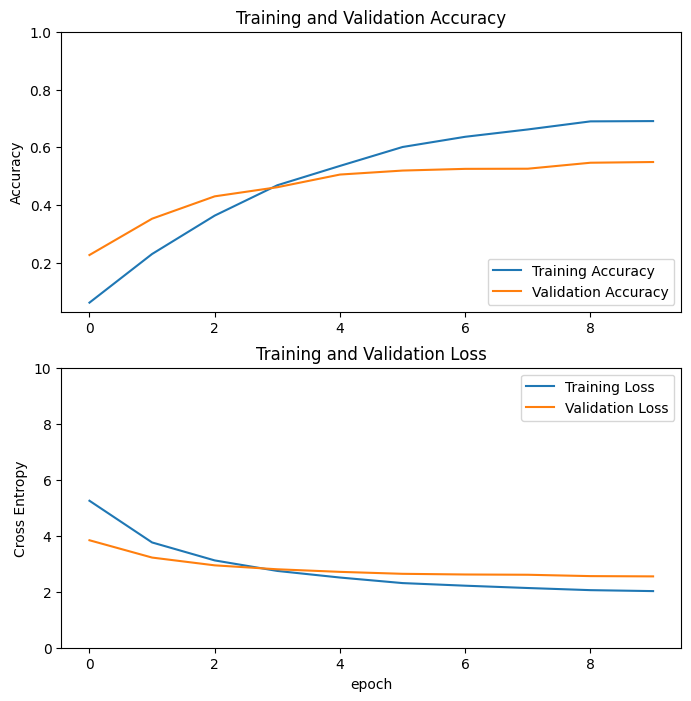

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,10.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
checkpoint_path = '/content/drive/MyDrive/Model/FinalResnet_Final/resnet_phase1_head.keras'

# โหลดน้ำหนัก (Weights) กลับมา
print(f"⏳ Loading weights from {checkpoint_path}...")
try:
    model.load_weights(checkpoint_path)
    print("Load สำเร็จ!")
except Exception as e:
    print(f"Load ไม่ได้: {e}")

⏳ Loading weights from /content/drive/MyDrive/Model/FinalResnet/resnet50_phase1_head.keras...
Load สำเร็จ!


## Finetune

In [ ]:
base_model.trainable = True

optimizer_tune = tf.keras.optimizers.SGD(learning_rate=0.005, momentum=0.9, decay=0.0001)

model.compile(optimizer=optimizer_tune,
              loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
              metrics=['accuracy'])

model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/optimizers/base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 448, 448, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 14, 14, 2048)   │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 2048)           │         8,192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 196)            │       100,548 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,747,588 (94.40 MB)

 Trainable params: 24,689,348 (94.18 MB)

 Non-trainable params: 58,240 (227.50 KB)

In [ ]:
history2 = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=35,
    callbacks=callbacks_phase2
)

save_history_pickle(history2, 'history_phase2.pkl')

Epoch 1/35
383/383 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step - accuracy: 0.1353 - loss: 4.8615
Epoch 1: val_accuracy improved from -inf to 0.19212, saving model to /content/drive/MyDrive/Model/FinalResnet_Final/models/resnet_best_final.keras
383/383 ━━━━━━━━━━━━━━━━━━━━ 206s 343ms/step - accuracy: 0.1354 - loss: 4.8607 - val_accuracy: 0.1921 - val_loss: 4.3034 - learning_rate: 0.0050
Epoch 2/35
383/383 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step - accuracy: 0.2600 - loss: 3.7366
Epoch 2: val_accuracy improved from 0.19212 to 0.32808, saving model to /content/drive/MyDrive/Model/FinalResnet_Final/models/resnet_best_final.keras
383/383 ━━━━━━━━━━━━━━━━━━━━ 82s 212ms/step - accuracy: 0.2603 - loss: 3.7353 - val_accuracy: 0.3281 - val_loss: 3.3043 - learning_rate: 0.0050
Epoch 3/35
382/383 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step - accuracy: 0.5584 - loss: 2.4101
Epoch 3: val_accuracy improved from 0.32808 to 0.49507, saving model to /content/drive/MyDrive/Model/FinalResnet_Final/models/resnet_best_final.keras


In [ ]:
checkpoint_path = '/content/drive/MyDrive/Model/FinalResnet_Final/models/resnet_best_final.keras'
print(f"⏳ Resuming from checkpoint: {checkpoint_path}")
try:
    model.load_weights(checkpoint_path)
    print("Load สำเร็จ")
except Exception as e:
    print(f"Load ไม่ได้: {e}")

⏳ Resuming from checkpoint: /content/drive/MyDrive/Model/FinalResnet_Final/models/resnet_best_final.keras
Load สำเร็จ


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'loss_scale_optimizer', because it has 4 variables whereas the saved optimizer has 226 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'SGD', because it has 2 variables whereas the saved optimizer has 222 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [ ]:
base_model.trainable = True

optimizer_fine = tf.keras.optimizers.SGD(learning_rate=0.0005, momentum=0.9, decay=0.0001)

model.compile(optimizer=optimizer_fine,
              loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
              metrics=['accuracy'])

callbacks_final = [
    tf.keras.callbacks.EarlyStopping(patience=8, restore_best_weights=True, verbose=1),
    tf.keras.callbacks.ModelCheckpoint(
        filepath='/content/drive/MyDrive/Model/FinalResnet_Final/models/resnet50_final_final_final.keras',
        save_best_only=True, monitor='val_accuracy', mode='max', verbose=1
    ),
    tf.keras.callbacks.ReduceLROnPlateau(factor=0.2, patience=2, min_lr=1e-6),
    tf.keras.callbacks.CSVLogger(
        os.path.join(LOG_DIR, 'log_phase3.csv'),
        separator=',', append=True
    )
]

In [ ]:
history_final = model.fit(
    train_ds,
    validation_data=val_ds,
    initial_epoch=35,
    epochs=50,
    callbacks=callbacks_final
)

save_history_pickle(history_final, 'history_phase3.pkl')

Epoch 36/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step - accuracy: 0.9770 - loss: 1.2535
Epoch 36: val_accuracy improved from -inf to 0.79409, saving model to /content/drive/MyDrive/Model/FinalResnet_Final/models/resnet50_final_final_final.keras
383/383 ━━━━━━━━━━━━━━━━━━━━ 177s 315ms/step - accuracy: 0.9770 - loss: 1.2535 - val_accuracy: 0.7941 - val_loss: 1.7274 - learning_rate: 5.0000e-04
Epoch 37/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step - accuracy: 0.9837 - loss: 1.2243
Epoch 37: val_accuracy improved from 0.79409 to 0.79557, saving model to /content/drive/MyDrive/Model/FinalResnet_Final/models/resnet50_final_final_final.keras
383/383 ━━━━━━━━━━━━━━━━━━━━ 83s 216ms/step - accuracy: 0.9837 - loss: 1.2243 - val_accuracy: 0.7956 - val_loss: 1.7200 - learning_rate: 5.0000e-04
Epoch 38/50
382/383 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step - accuracy: 0.9824 - loss: 1.2303
Epoch 38: val_accuracy did not improve from 0.79557
383/383 ━━━━━━━━━━━━━━━━━━━━ 81s 210ms/step - accuracy: 0.9825 - lo

KeyboardInterrupt: 

## Model sanity check

In [ ]:
# เช็กว่าโมเดล output shape ตรงกับจำนวนคลาส
x_sample = tf.random.normal((1, IMG_SIZE, IMG_SIZE, 3))
y_pred = model(x_sample)
print("✅ Output shape:", y_pred.shape)
print("✅ Sum of softmax probabilities:", tf.reduce_sum(y_pred).numpy())

assert y_pred.shape[-1] == NUM_CLASSES, "❌ Output class ไม่ตรงกับจำนวนคลาส!"
print("✅ Number of output classes matches:", NUM_CLASSES)

✅ Output shape: (1, 196)
✅ Sum of softmax probabilities: 1.0000001
✅ Number of output classes matches: 196


✅ Image batch shape: (16, 448, 448, 3)
✅ Label batch shape: (16, 196)
มีทั้งหมด 196 classes ตัวอย่างเช่น: ['AM General Hummer SUV 2000', 'Acura Integra Type R 2001', 'Acura RL Sedan 2012', 'Acura TL Sedan 2012', 'Acura TL Type-S 2008', 'Acura TSX Sedan 2012', 'Acura ZDX Hatchback 2012', 'Aston Martin V8 Vantage Convertible 2012', 'Aston Martin V8 Vantage Coupe 2012', 'Aston Martin Virage Convertible 2012']


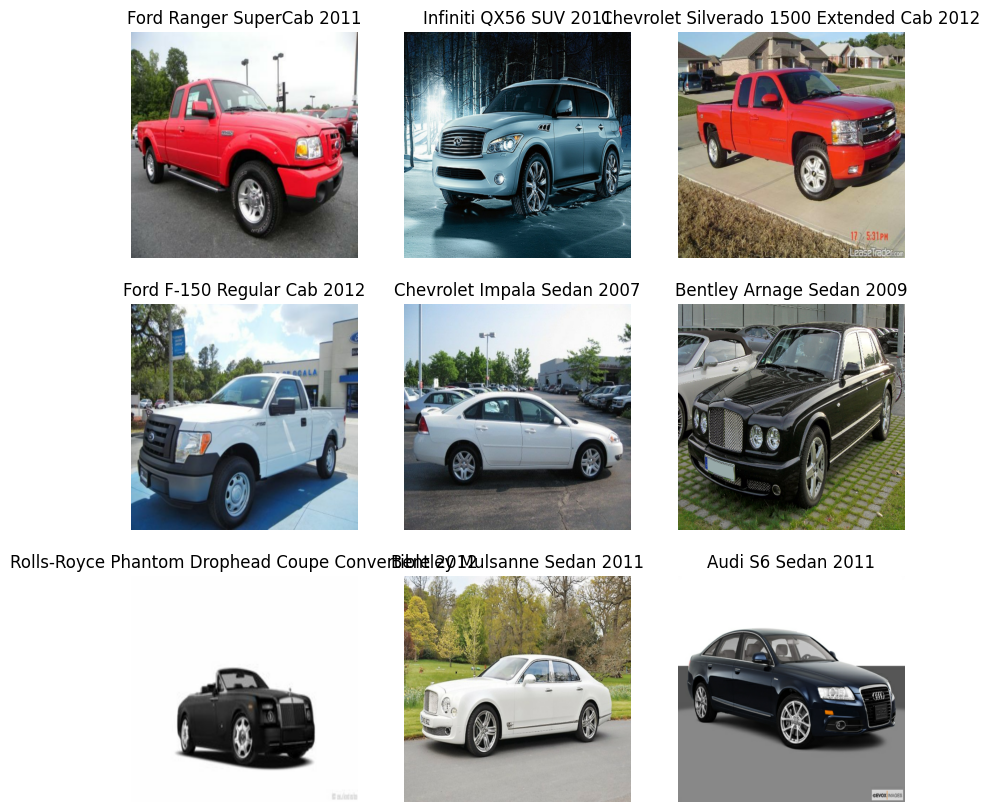

In [ ]:
# ดูข้อมูล batch ตัวอย่างจาก train_ds
images, labels = next(iter(train_ds))

print("✅ Image batch shape:", images.shape)
print("✅ Label batch shape:", labels.shape)

# ดูชื่อคลาสจาก directory
print(f"มีทั้งหมด {len(class_names)} classes ตัวอย่างเช่น:", class_names[:10])

# แสดงภาพตัวอย่าง 9 รูป พร้อม label ที่ตรงจาก class_names
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    label_idx = np.argmax(labels[i].numpy())
    plt.title(class_names[label_idx])
    plt.axis("off")
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step


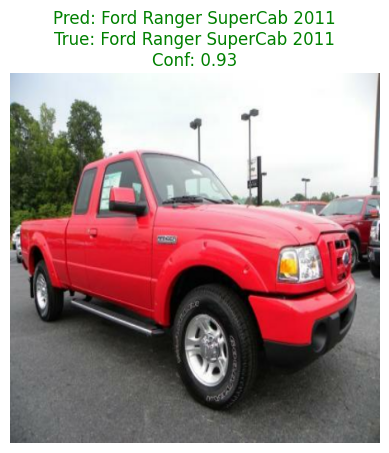

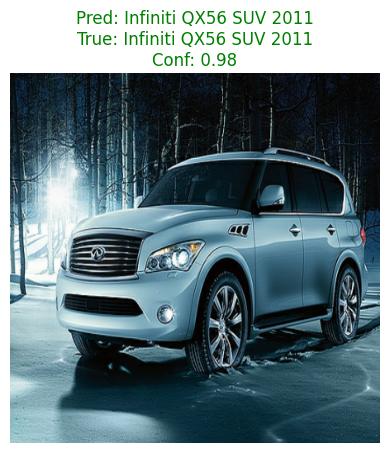

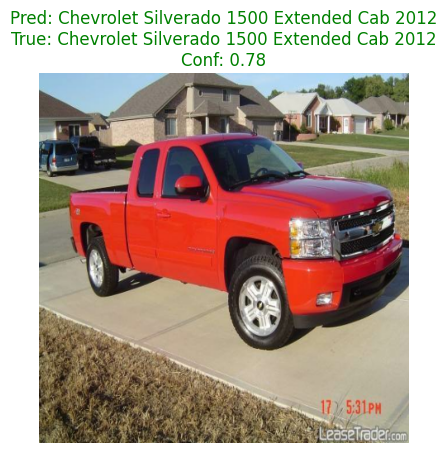

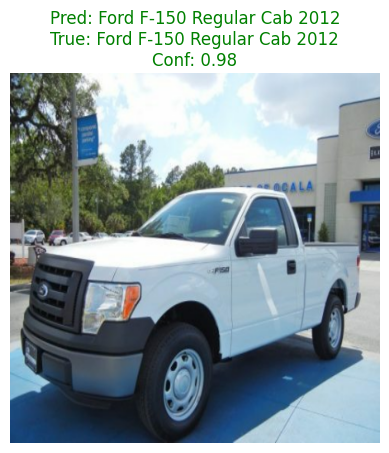

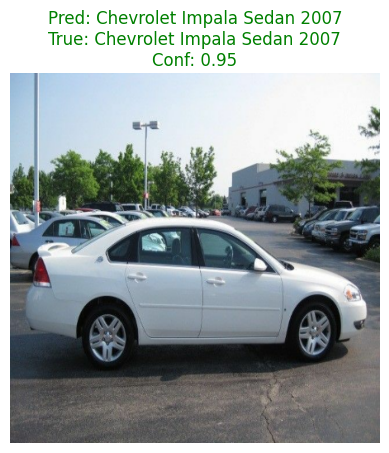

In [ ]:
# ลองให้โมเดล predict ภาพ batch แรก (เช็กว่าไม่ crash และมีความมั่นใจ)
preds = model.predict(images[:5])

for i in range(5):
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.axis("off")
    true_label = class_names[np.argmax(labels[i])]
    pred_label = class_names[np.argmax(preds[i])]
    confidence = np.max(preds[i])
    color = "green" if true_label == pred_label else "red"
    plt.title(f"Pred: {pred_label}\nTrue: {true_label}\nConf: {confidence:.2f}", color=color)
    plt.show()

In [ ]:
# ตรวจค่า NaN หรือ infinity ใน weight ของโมเดล
for layer in model.layers:
    for weight in layer.weights:
        w = weight.numpy()
        if np.isnan(w).any() or np.isinf(w).any():
            print(f"⚠️ พบ NaN/Inf ใน layer: {layer.name}")
print("✅ ไม่มี NaN/Inf ในโมเดล")

✅ ไม่มี NaN/Inf ในโมเดล


# Save Model

In [ ]:
save_path = '/content/drive/MyDrive/Model/FinalResnet_Final/models/resnet50_final.keras'

# 1. สร้างโฟลเดอร์ก่อนเสมอ (กัน Error)
os.makedirs(os.path.dirname(save_path), exist_ok=True)

# 2. เซฟโมเดล
model.save(save_path)
print(f"Model saved successfully at: {save_path}")

Model saved successfully at: /content/drive/MyDrive/Model/FinalResnet_Final/resnet50_final.keras


# Evaluate

In [ ]:
# Evaluate บน Test Set
test_loss, test_acc = model.evaluate(test_ds)
print(f"✅ Test Accuracy: {test_acc:.4f}")
print(f"✅ Test Loss: {test_loss:.4f}")

503/503 ━━━━━━━━━━━━━━━━━━━━ 65s 129ms/step - accuracy: 0.7735 - loss: 1.7810
✅ Test Accuracy: 0.8001
✅ Test Loss: 1.7135


⏳ Loading best model: /content/drive/MyDrive/Model/FinalResnet_Final/models/resnet50_final_final_final.keras


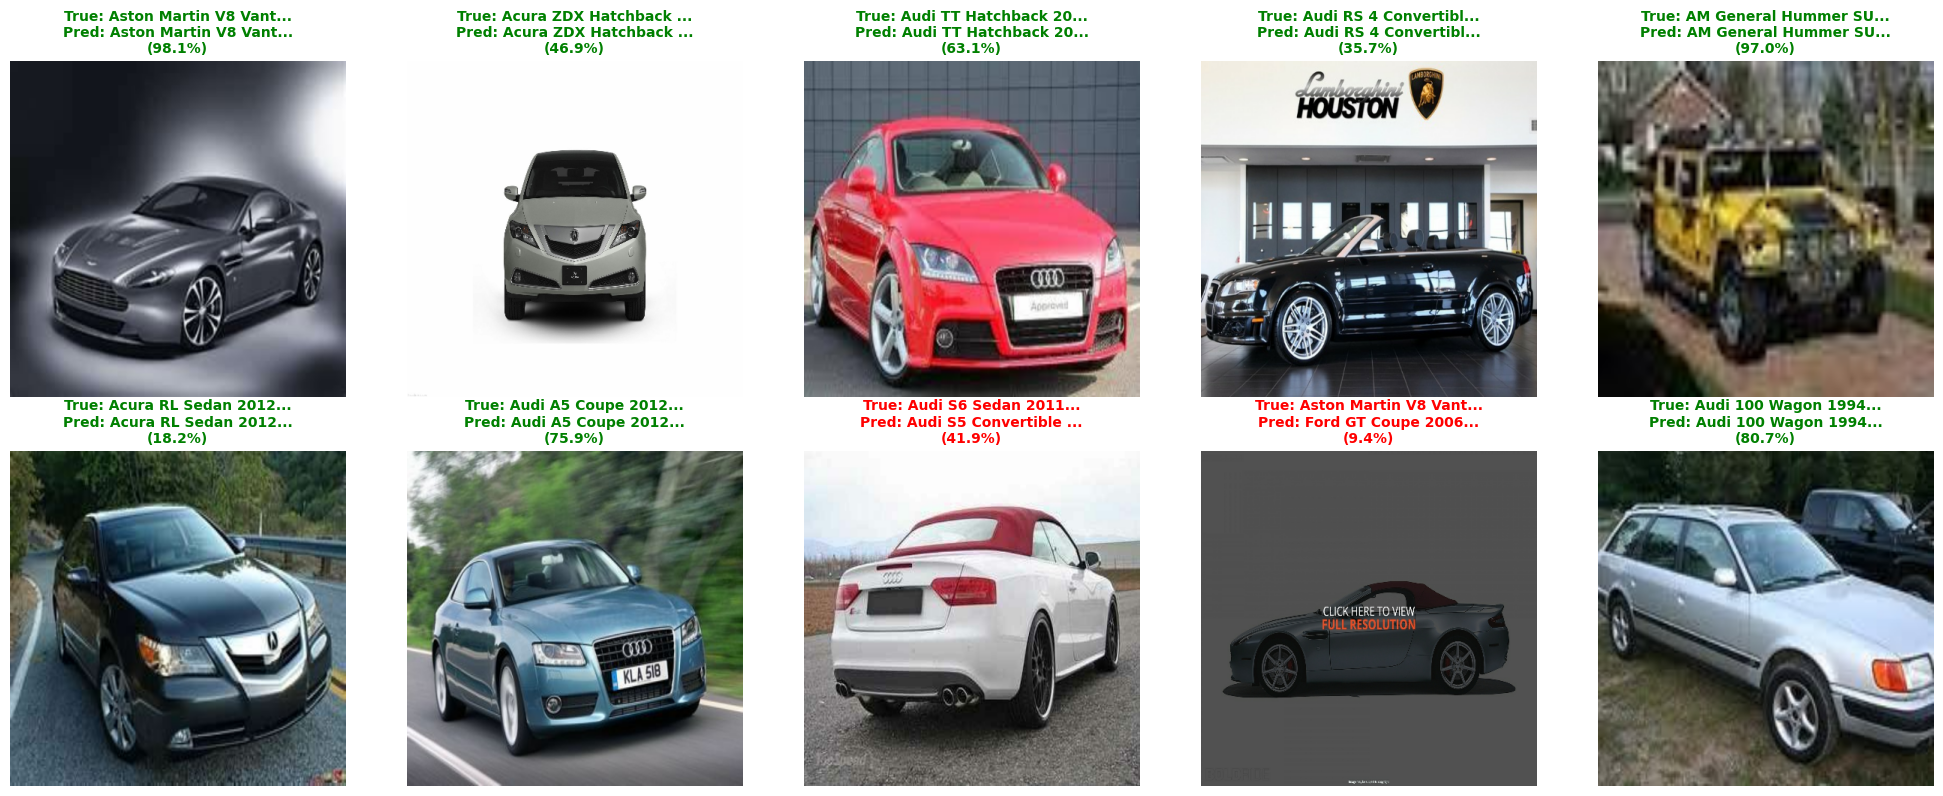

In [ ]:
best_model_path = os.path.join(MODEL_DIR, 'resnet50_final_final_final.keras')
print(f"⏳ Loading best model: {best_model_path}")
final_model = tf.keras.models.load_model(best_model_path)

pool_images = []
pool_labels = []

for i, (batch_imgs, batch_lbls) in enumerate(test_ds):
    if i % 3 == 0: # กระโดดข้าม Batch เพื่อให้ได้รถหลากหลายรุ่น
        # สุ่มหยิบ 1 รูปจากใน Batch นี้
        rand_idx = random.randint(0, len(batch_imgs) - 1)
        pool_images.append(batch_imgs[rand_idx])
        pool_labels.append(batch_lbls[rand_idx])

    # พอได้ครบสัก 20-30 รูปก็พอแล้ว (เยอะไปเดี๋ยวช้า)
    if len(pool_images) >= 20:
        break

indices = random.sample(range(len(pool_images)), min(10, len(pool_images)))

plt.figure(figsize=(20, 8))

for i, idx in enumerate(indices):
    img = pool_images[idx]
    label = pool_labels[idx]

    # Predict
    img_input = tf.expand_dims(img, 0)
    pred = final_model.predict(img_input, verbose=0)

    # Decode Result
    true_idx = np.argmax(label)
    pred_idx = np.argmax(pred)
    true_name = class_names[true_idx]
    pred_name = class_names[pred_idx]
    conf = np.max(pred) * 100

    # Plot
    ax = plt.subplot(2, 5, i + 1)
    plt.imshow(img.numpy().astype("uint8"))

    col = "green" if true_idx == pred_idx else "red"

    # จัด Format ชื่อให้สั้นลงหน่อยถ้ามันยาวไป
    title = f"True: {true_name[:20]}...\nPred: {pred_name[:20]}...\n({conf:.1f}%)"
    plt.title(title, color=col, fontsize=10, fontweight='bold')
    plt.axis("off")

plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

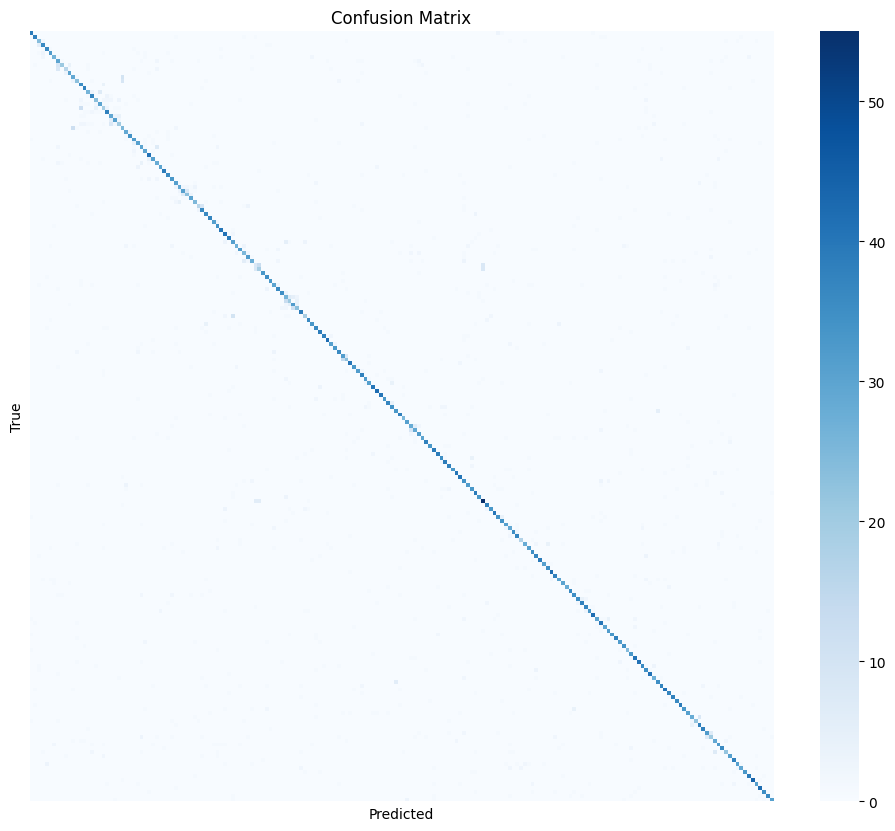

📄 Classification Report:
                                                        precision    recall  f1-score   support

                            AM General Hummer SUV 2000       0.87      0.89      0.88        44
                             Acura Integra Type R 2001       0.90      0.86      0.88        44
                                   Acura RL Sedan 2012       0.71      0.75      0.73        32
                                   Acura TL Sedan 2012       0.77      0.84      0.80        43
                                  Acura TL Type-S 2008       0.88      0.86      0.87        42
                                  Acura TSX Sedan 2012       0.84      0.80      0.82        40
                              Acura ZDX Hatchback 2012       0.84      0.67      0.74        39
              Aston Martin V8 Vantage Convertible 2012       0.52      0.67      0.58        45
                    Aston Martin V8 Vantage Coupe 2012       0.88      0.51      0.65        41
              

In [ ]:
# รวมผลลัพธ์ทั้งหมดจาก test_ds
y_true = []
y_pred = []

for images, labels in test_ds:
    preds = model.predict(images)
    y_true.extend(np.argmax(labels.numpy(), axis=1))
    y_pred.extend(np.argmax(preds, axis=1))

# แปลงเป็น numpy array
y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(12, 10))
sns.heatmap(cm, cmap='Blues', xticklabels=False, yticklabels=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# Classification Report
print("📄 Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

✅ Loaded all 3 history files successfully!


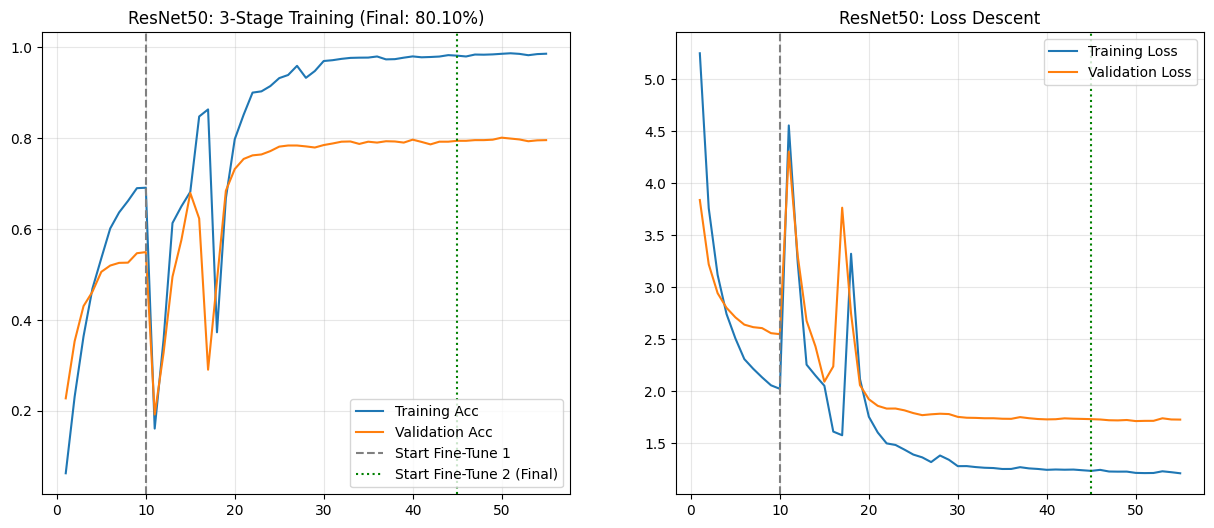

In [ ]:
def merge_and_plot_3_phases_from_log(h1_path, h2_path, h3_path):
    """รวมร่างกราฟ 3 ช่วง (รองรับทั้ง CSV Log และ Pickle)"""

    # ฟังก์ชันช่วยโหลดไฟล์ (เช็คว่าเป็น CSV หรือ Pickle)
    def load_file(path):
        if path.endswith('.csv'):
            # อ่าน CSV แล้วแปลงเป็น Dict เหมือน History ปกติ
            return pd.read_csv(path).to_dict(orient='list')
        elif path.endswith('.pkl'):
            with open(path, 'rb') as f:
                return pickle.load(f)
        else:
            raise ValueError(f"Unknown file format: {path}")

    try:
        h1 = load_file(h1_path)
        h2 = load_file(h2_path)
        h3 = load_file(h3_path)
        print("✅ Loaded all 3 history files successfully!")
    except Exception as e:
        print(f"⚠️ Error loading files: {e}")
        return

    # รวม History
    full_history = {}
    # ใช้ keys จาก h1 เป็นหลัก (accuracy, loss, etc.)
    for key in h1.keys():
        # เชื่อม list ของทั้ง 3 เฟสเข้าด้วยกัน
        # .get(key, []) กันเหนียวเผื่อบางไฟล์ไม่มี key นั้น
        full_history[key] = h1.get(key, []) + h2.get(key, []) + h3.get(key, [])

    acc = full_history['accuracy']; val_acc = full_history['val_accuracy']
    loss = full_history['loss']; val_loss = full_history['val_loss']

    epochs = range(1, len(acc) + 1)

    # จุดตัดแบ่งเฟส (คำนวณจากความยาวของข้อมูลจริง)
    split_1 = len(h1['accuracy']) # จบ Phase 1
    split_2 = split_1 + len(h2['accuracy']) # จบ Phase 2

    plt.figure(figsize=(15, 6))

    # --- Accuracy Plot ---
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, label='Training Acc')
    plt.plot(epochs, val_acc, label='Validation Acc')

    # เส้นแบ่งเฟส
    plt.axvline(x=split_1, color='gray', linestyle='--', label='Start Fine-Tune 1')
    plt.axvline(x=split_2, color='green', linestyle=':', label='Start Fine-Tune 2 (Final)')

    # หาค่า Acc สูงสุดมาโชว์
    max_acc = max(val_acc) if len(val_acc) > 0 else 0
    plt.title(f'ResNet50: 3-Stage Training (Final: {max_acc*100:.2f}%)')
    plt.legend(loc='lower right')
    plt.grid(True, alpha=0.3)

    # --- Loss Plot ---
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, label='Training Loss')
    plt.plot(epochs, val_loss, label='Validation Loss')

    # เส้นแบ่งเฟส
    plt.axvline(x=split_1, color='gray', linestyle='--')
    plt.axvline(x=split_2, color='green', linestyle=':')

    plt.title('ResNet50: Loss Descent')
    plt.legend(loc='upper right')
    plt.grid(True, alpha=0.3)

    plt.show()

# ==========================================
# เรียกใช้ (ชี้ไปที่ไฟล์ CSV ในโฟลเดอร์ logs)
# ==========================================
# ตรวจสอบ path ของคุณให้ดีว่าเก็บ log ไว้ที่ไหน (ปกติถ้าใช้โค้ดผมจะอยู่ที่ logs/)
path1 = os.path.join(LOG_DIR, 'log_phase1.csv')
path2 = os.path.join(LOG_DIR, 'log_phase2.csv')
path3 = os.path.join(LOG_DIR, 'log_phase3.csv')

# เช็คก่อนว่าไฟล์มีอยู่จริงไหม
if os.path.exists(path1) and os.path.exists(path2) and os.path.exists(path3):
    merge_and_plot_3_phases_from_log(path1, path2, path3)
else:
    print("❌ หาไฟล์ Log ไม่เจอครับ กรุณาเช็ค path ในตัวแปร path1, path2, path3")
    # ลอง print path ออกมาดูถ้าหาไม่เจอ
    print(f"Path1: {path1}")

🔍 Top 10 Confusing Classes:
- Chevrolet Express Cargo Van 2007
- Audi S5 Coupe 2012
- Audi TTS Coupe 2012
- Spyker C8 Coupe 2009
- Aston Martin Virage Convertible 2012
- Bugatti Veyron 16.4 Convertible 2009
- Aston Martin V8 Vantage Coupe 2012
- Chevrolet Tahoe Hybrid SUV 2012
- Chevrolet Silverado 1500 Hybrid Crew Cab 2012
- Chevrolet Express Van 2007


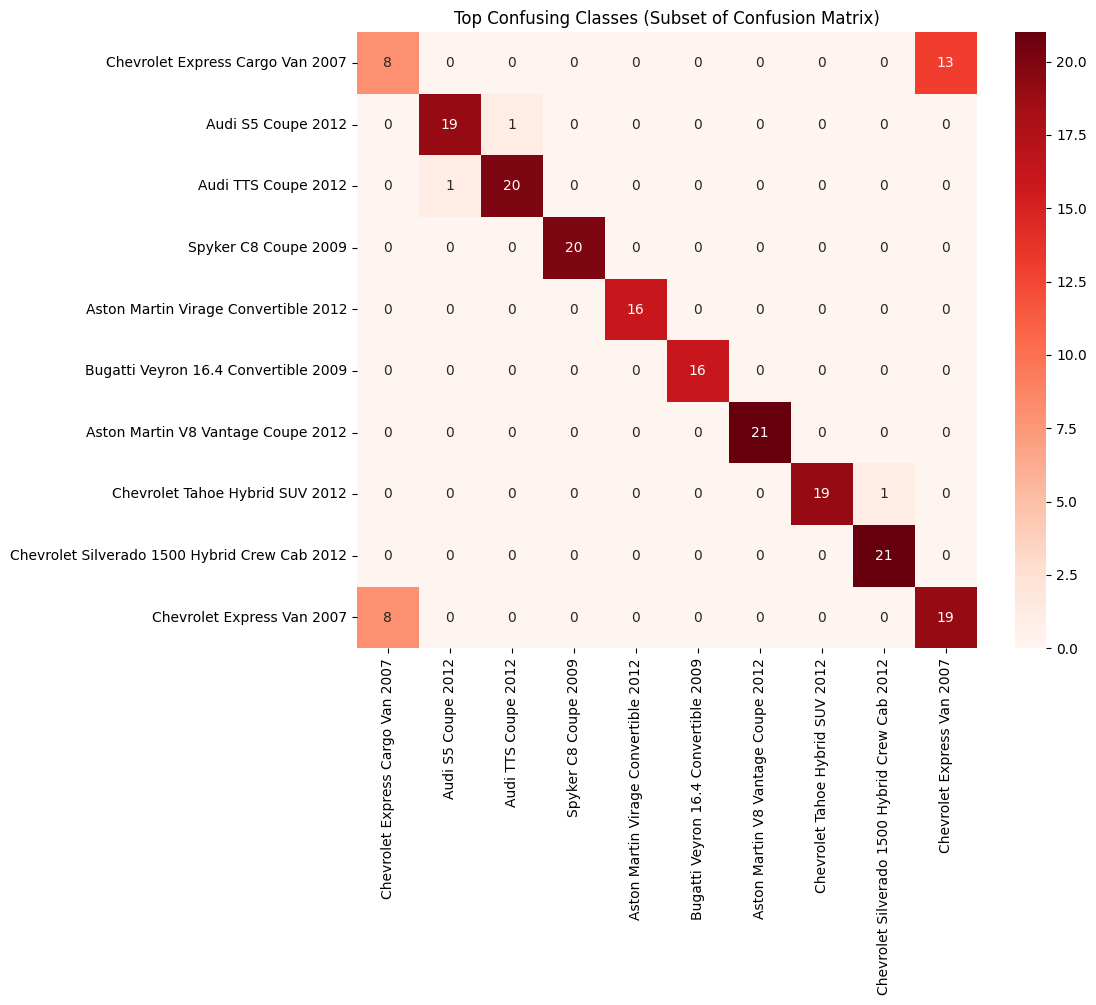

In [ ]:
# หาค่า FP และ FN รวมของแต่ละคลาส
cm_sum = np.sum(cm, axis=1, keepdims=True)
cm_norm = cm.astype('float') / cm_sum
np.fill_diagonal(cm_norm, 0)
confused_scores = cm_norm.sum(axis=1)

# หา top 10 class ที่สับสนมากที่สุด
top_confused = np.argsort(confused_scores)[-10:][::-1]

print("🔍 Top 10 Confusing Classes:")
for i in top_confused:
    print(f"- {class_names[i]}")

# แสดง matrix เฉพาะคลาสที่สับสนมากสุด
plt.figure(figsize=(10, 8))
sns.heatmap(cm[top_confused][:, top_confused],
            xticklabels=[class_names[i] for i in top_confused],
            yticklabels=[class_names[i] for i in top_confused],
            cmap="Reds", annot=True, fmt="d")
plt.title("Top Confusing Classes (Subset of Confusion Matrix)")
plt.show()